In [8]:
import numpy as np
import matplotlib.pyplot as plt
import glob as g
import pandas as pd

In [9]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('seaborn-v0_8')

In [10]:
file = sorted(g.glob('output_rrtm_MLS-clr*'))
print(file)

finput = sorted(g.glob('input_rrtm_MLS-clr*'))
print(finput)

['output_rrtm_MLS-clr', 'output_rrtm_MLS-clr-CO2', 'output_rrtm_MLS-clr-H2O', 'output_rrtm_MLS-clr-O3', 'output_rrtm_MLS-clr-XXH2O']
['input_rrtm_MLS-clr', 'input_rrtm_MLS-clr-CO2', 'input_rrtm_MLS-clr-H2O', 'input_rrtm_MLS-clr-O3', 'input_rrtm_MLS-clr-sw']


The above file(s) can be aptly modified according to available i/o files. The input reader is compatible with standard input tape files and the output reader customised for 16 band solutions using rrtmg. The input function can be improvised to read other data as well.

The following functions read values from rrtmg-lw input/output files and store them in variables. This can be used to study heating profiles of the atmosphere under set conditions.

In [17]:
#This is for custom reading - for input files
# Output yields layer-wise pressure and temperature

def rrtmg_lw_input_read(nlev, file):
    temparr = np.empty(0);
    parr = np.empty(0);
    tave = np.empty(0);
    pave = np.empty(0);
    mix_ratio = np.array([[0.0 for x in range(8)]for y in range(51)]);
    
    fi = open(finput[0], 'r')
    lines = fi.readlines()[0:]

    line7 = lines[7].split()
    #Updating pressure and temperature for top and bottom of 1st layer separately
    temparr = np.append(temparr, line7[5])
    parr = np.append(parr, line7[4])
    temparr = np.append(temparr, line7[8])
    parr = np.append(parr, line7[7])
    tave = np.append(tave, line7[1]);
    pave = np.append(pave, line7[0]);    

    for j in range(9,nlev,2):
       tmp1 = lines[j];
       tmpave = tmp1.split();
       tave = np.append(tave, tmpave[1]);
       pave = np.append(pave, tmpave[0]);
       indices = [71];
       tmp2 = [tmp1[i:j] for i,j in zip(indices, indices[1:]+[None])];
       tmp3 = np.empty([0,0])
       for val in tmp2:
        tmp3 = np.append(tmp3, val.split())
       temparr = np.append(temparr, tmp3[1])
       parr = np.append(parr, tmp3[0])

    for j in range(8, nlev, 2):
       tmp1 = lines[j]
       tmp2 = tmp1.split()
       for u in range(0,len(tmp2)):
           tmp2[u] = float(tmp2[u])
       # print(tmp2)
       for k in range(0,len(tmp2)):
         mix_ratio[(j-8)//2][k] = tmp2[k]
        
    temparr = [float(val) for val in temparr]
    parr = [float(value) for value in parr]
    tave = [float(val) for val in tave]
    pave = [float(value) for value in pave]    
    fi.close()

    return temparr, parr, tave, pave, mix_ratio

In [18]:
#This is for custom reading - for outputs that are partitioned into data based on wavenumber bands.
# A search with a certain wavenumber string would yield a relevant output

def rrtmg_lw_output_read(nlev, file, string):
    lvl = np.full(nlev,np.nan);
    prs = np.full(nlev,np.nan);
    fup = np.full(nlev,np.nan);
    fdn = np.full(nlev,np.nan);
    fnt = np.full(nlev,np.nan);
    htr = np.full(nlev,np.nan);
    
    fi  = open(file,'r')
    lines = fi.readlines()[0:]
    for row in lines:
        # check if string present on a current line
        word = string
        # if found it returns index of the first occurrence of the substring
        if row.find(word) != -1:
            print('string exists in file')
            index = lines.index(row)
            #print(index)
            lines = lines[index+3:]
            break
    
    #print(lines)
    

    for j in range(0,nlev):

        tmp1 = lines[j];
        tmp2 = tmp1.split();
        lvl[j] = tmp2[0];
        prs[j] = tmp2[1];
        fup[j] = tmp2[2];
        fdn[j] = tmp2[3];
        fnt[j] = tmp2[4];
        htr[j] = tmp2[5]; 
        
    lvl = lvl[::-1]
    prs = prs[::-1]
    fup = fup[::-1]
    fdn = fdn[::-1]
    fnt = fnt[::-1]
    htr = htr[::-1]
    
    fi.close()
    return lvl,prs,fnt,htr,string,fup,fdn


Wavenumber ranges:<br>

Total:  
10.0 - 3250.0

Partitions (can be used as search strings):<br>
```
10.0 -  350.0 
350.0 -  500.0 
500.0 -  630.0 
630.0 -  700.0 
700.0 -  820.0 
820.0 -  980.0 
980.0 - 1080.0 
1080.0 - 1180.0 
1180.0 - 1390.0 
1390.0 - 1480.0 
1480.0 - 1800.0 
1800.0 - 2080.0 
2080.0 - 2250.0 
2250.0 - 2380.0 
2380.0 - 2600.0 
2600.0 - 3250.0
```
Define an array for all strings:
```
bands = np.array(['10.0 -  350.0', '350.0 -  500.0', '500.0 -  630.0', '630.0 -  700.0', '700.0 -  820.0','820.0 -  980.0', '980.0 - 1080.0', '1080.0 - 1180.0', '1180.0 - 1390.0', '1390.0 - 1480.0', '1480.0 - 1800.0',  '1800.0 - 2080.0', '2080.0 - 2250.0', '2250.0 - 2380.0', '2380.0 - 2600.0', '2600.0 - 3250.0'])
```

A simple function to return the 16 bands for ease of access. Then final entry is the total bandwidth.

In [19]:
def return_bands():
    bands = np.array(['10.0 -  350.0', '350.0 -  500.0', '500.0 -  630.0', '630.0 -  700.0', '700.0 -  820.0','820.0 -  980.0', '980.0 - 1080.0', '1080.0 - 1180.0', '1180.0 - 1390.0', '1390.0 - 1480.0', '1480.0 - 1800.0',  '1800.0 - 2080.0', '2080.0 - 2250.0', '2250.0 - 2380.0', '2380.0 - 2600.0', '2600.0 - 3250.0', '10.0 - 3250.0'])
    return bands

In [20]:
input_mls = rrtmg_lw_input_read(109, finput[0])
# print(input_mls[0][1:])

In [21]:
output_51l = rrtmg_lw_output_read(51,file[0],return_bands()[16]) #Midlattitude summer sky, clear conditions, 51 layers
print(output_51l[3])

string exists in file
[ -1.91914  -1.87132  -1.92318  -2.01794  -1.90315  -1.84856  -1.80221
  -1.81234  -1.81651  -1.85322  -1.96363  -2.25507  -2.21695  -1.68056
  -1.00227  -0.19681  -0.09646  -0.124    -0.16499  -0.24152  -0.36
  -0.50141  -0.68583  -0.8815   -1.08278  -1.25371  -1.46945  -1.66345
  -2.00705  -2.52675  -3.1955   -3.88304  -4.69554  -5.43057  -6.42557
  -7.7633   -9.46652 -11.28339 -11.90749 -10.35905  -8.96232  -8.47503
  -7.61268  -7.11965  -6.98611  -6.69715  -6.01722  -5.69915  -5.64058
 -22.84141   0.     ]


The following plots show the input profiles for atmospheric pressure and temperature for a standard mid lattitude summer atmosphere with clear skies.

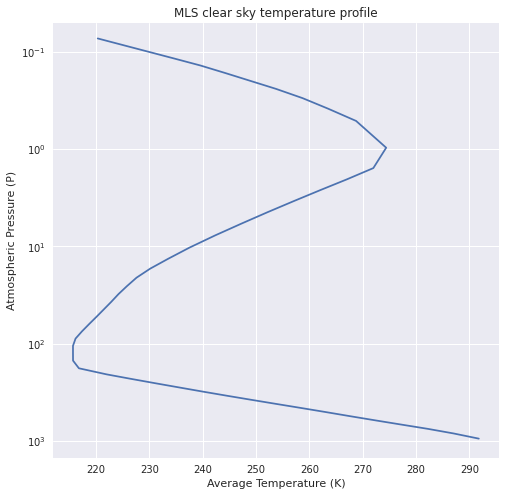

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(input_mls[2], input_mls[3])
ax.set_xlabel('Average Temperature (K)')
ax.set_ylabel('Atmospheric Pressure (P)')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS clear sky temperature profile')
plt.savefig('MLS Temp.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Mid-lattitude summer atmospheric pressure profile for clear skies')

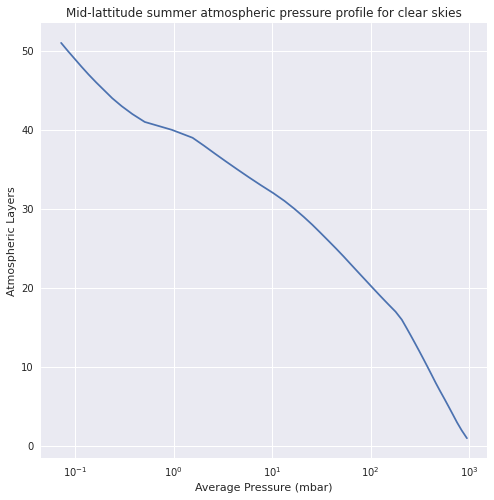

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(input_mls[3], output_51l[0])
ax.set_xlabel('Average Pressure (mbar)')
ax.set_ylabel('Atmospheric Layers')
ax.set_xscale('log')
ax.set_title('Mid-lattitude summer atmospheric pressure profile for clear skies')

Text(0.5, 1.0, 'Mid-lattitude summer atmospheric pressure vs temperature profile for clear skies')

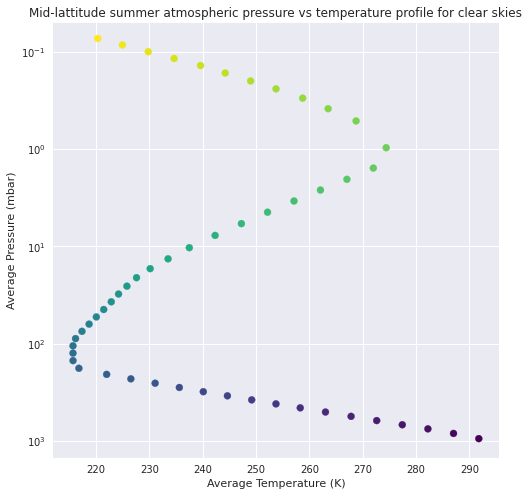

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(input_mls[2], input_mls[3], c=output_51l[0], cmap='viridis')
ax.set_ylabel('Average Pressure (mbar)')
ax.set_xlabel('Average Temperature (K)')
ax.set_ylim(1500, 0.05)
ax.set_yscale('log')
ax.set_title('Mid-lattitude summer atmospheric pressure vs temperature profile for clear skies')
# Colormap is set as following: Darker colors correspond to lower altitudes and lighter for higher ones

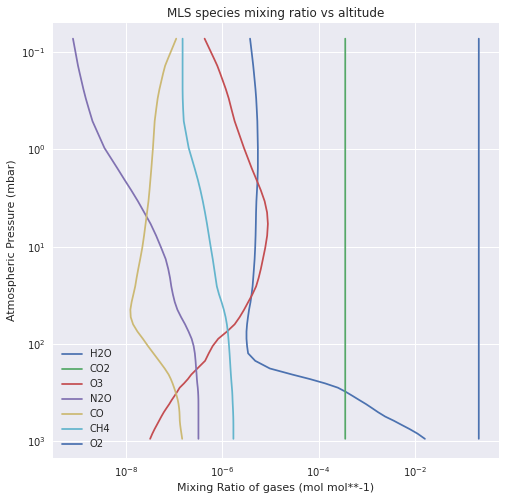

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
for k in range(0,7):
    ax.plot(input_mls[4][:,k], input_mls[3])
ax.set_xlabel('Mixing Ratio of gases (mol mol**-1)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS species mixing ratio vs altitude')
ax.legend(['H2O','CO2','O3','N2O','CO','CH4','O2'])
plt.savefig('mix-ratio.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'MLS heating rate for clear skies')

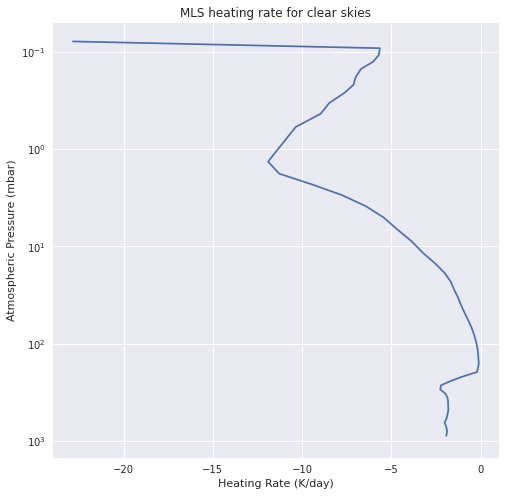

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_51l[3][:-1], output_51l[1][:-1])
ax.set_xlabel('Heating Rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS heating rate for clear skies')

In [27]:
output_noco2 = rrtmg_lw_output_read(51,file[1],return_bands()[16]) #no CO2
output_noh2o = rrtmg_lw_output_read(51,file[2],return_bands()[16]) #no H2O
output_noo3 = rrtmg_lw_output_read(51,file[3],return_bands()[16]) #no O3
# print(output_51l[0])

string exists in file
string exists in file
string exists in file


The following plots are for heating rate and net upward flux as output of rrtmg given the above input conditions.

Text(0.5, 1.0, 'MLS heating rate for clear skies, full bandwidth')

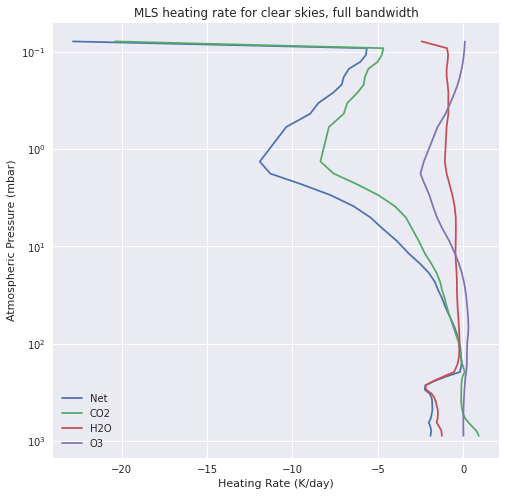

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_51l[3][:-1], output_51l[1][:-1], label='Net')
ax.plot(output_51l[3][:-1]-output_noco2[3][:-1], output_51l[1][:-1], label='CO2')
ax.plot(output_51l[3][:-1]-output_noh2o[3][:-1], output_51l[1][:-1], label='H2O')
ax.plot(output_51l[3][:-1]-output_noo3[3][:-1], output_51l[1][:-1], label='O3')
ax.set_xlabel('Heating Rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.legend()
ax.set_title('MLS heating rate for clear skies, full bandwidth')

Text(0.5, 1.0, 'MLS net upward radiative flux for clear skies, full bandwidth')

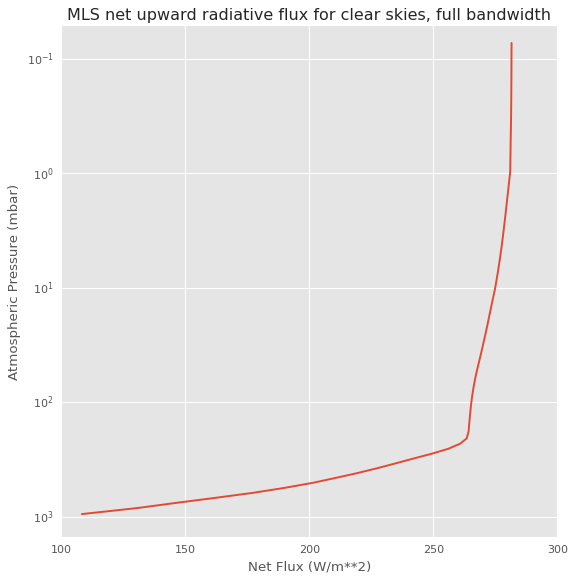

In [151]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_51l[2], input_mls[3])
ax.set_xlabel('Net Flux (W/m**2)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS net upward radiative flux for clear skies, full bandwidth')

string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file


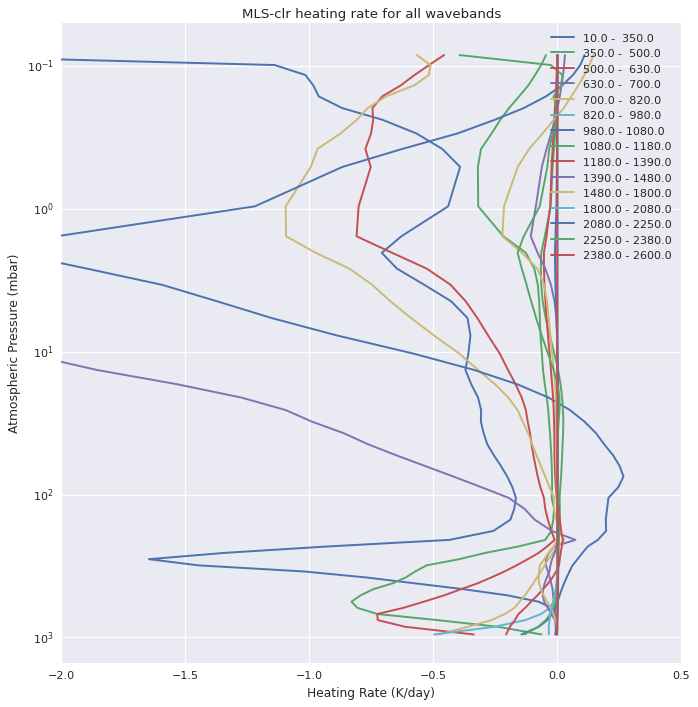

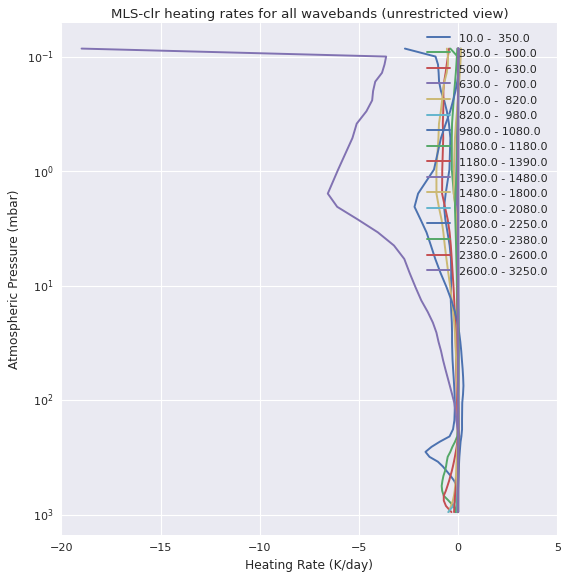

In [189]:
fig, ax = plt.subplots(figsize=(10,10))
for j in range(0,15):
    output_51l = rrtmg_lw_output_read(51,file[0],return_bands()[j])
    ax.plot(output_51l[3][:-1], input_mls[3][:-1], label=output_51l[4])
ax.set_xlabel('Heating Rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS-clr heating rate for all wavebands')
ax.set_xlim(-2, 0.5)
ax.legend()
plt.savefig('htr_bands.pdf', bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(8,8))
for j in range(0,16):
    output_51l = rrtmg_lw_output_read(51,file[0],return_bands()[j])
    ax2.plot(output_51l[3][:-1], input_mls[3][:-1], label=output_51l[4])
ax2.set_xlabel('Heating Rate (K/day)')
ax2.set_ylabel('Atmospheric Pressure (mbar)')
ax2.set_yscale('log')
ax2.set_ylim(1500,0.05)
ax2.set_title('MLS-clr heating rates for all wavebands (unrestricted view)')
ax2.legend()

string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file
string exists in file


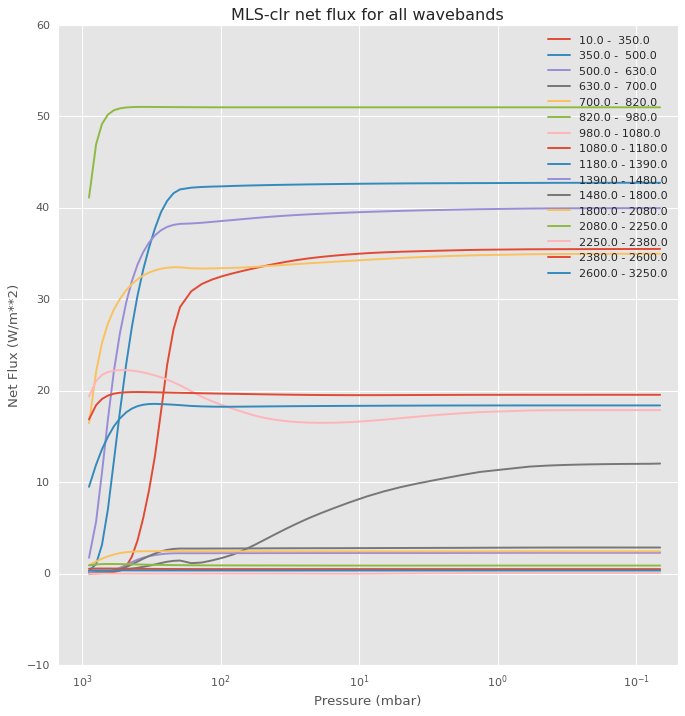

In [153]:
fig2, ax2 = plt.subplots(figsize=(10,10))
for j in range(0,16):
    output_51l = rrtmg_lw_output_read(51,file[0],return_bands()[j])
    ax2.plot(output_51l[1], output_51l[2], label=output_51l[4])

ax2.set_ylabel('Net Flux (W/m**2)')
ax2.set_xlabel('Pressure (mbar)')
ax2.set_title('MLS-clr net flux for all wavebands')
ax2.set_xscale('log')
ax2.set_xlim(1500,0.05)
ax2.legend()

In [182]:
output = rrtmg_lw_output_read(51,file[4],return_bands()[16]) #Midlattitude summer sky, clear conditions, 51 layers

string exists in file


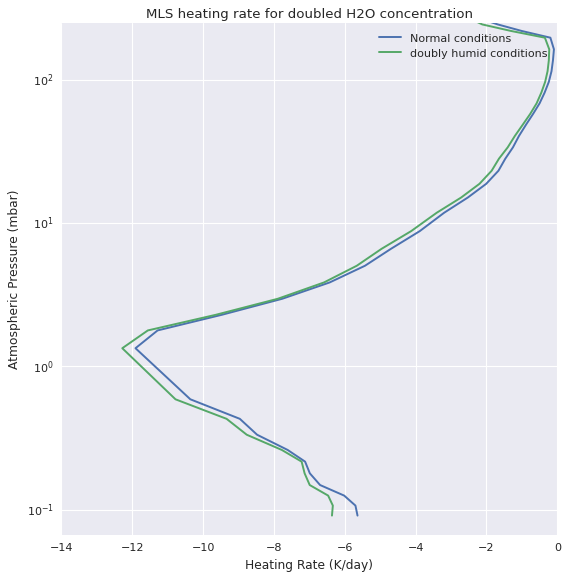

In [188]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_51l[3][:-2], output_51l[1][:-2], label='Normal conditions')
ax.plot(output[3][:-2], output[1][:-2], label='doubly humid conditions')
ax.set_xlabel('Heating Rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_yscale('log')
ax.set_ylim(min(output[1]),250)
ax.legend()
ax.set_title('MLS heating rate for doubled H2O concentration')
plt.savefig('htr-2h2o.pdf', bbox_inches='tight')